# Machine Learning e Processamento de Linguagem Natural (PLN) com modelos lineares

<img src="/images/nlp.png" width="2000"/>

## Tópicos

- Introdução
- Estudo de caso
- Importando bibliotecas
- Importando o conjunto de dados
- Preparação do texto
- Contando as palavras
- Transformando texto em vetor
- TF-IDF
- Multilabel Classifier
- Treinando e testando
- Avaliação
- Análises das variáveis mais importantes
- Tunando hiperparâmetros
- Conclusão
- Referências

## Introdução

Neste notebook, apresento o uso de Machine Learning com Regressão Logística e `Processamento de Linguagem Natural (PLN)`, o nosso objetivo é a previsão de tags com base em perguntas, com um conjunto de dados coletados do site Stack Overflow.

### O que é Processamento de Linguagem Natural?

Processamento de Linguagem Natural (PLN) ou *Natural Language Preprocessing (NLP na sigla inglesa)* é a interação do homem com a máquina através da linguagem natural. A linguagem natural é a forma mais comum de nos comunicarmos, que estamos acostumados desde o nascimento. O computador por outro lado, utiliza um linguagem de Programação, seja python, java, entre outros para processarem informações.

O **PLN** carrega uma série de **desafios em função da linguagem humana** (natural), pois carrega uma séries de regras e ambiguidades, sem falar do idioma, que também contribui.

Dessa forma, o principal desafio é conseguir **desenvolver sistemas digitais** capazes de entender a linguagem humana. Mas isso não vem de hoje e estamos constantementes em contato com essa tecnologia, como por exemplos: Mecanismos de busca, Assistentes virtuais, Análise de sentimento e chatbots.

É uma subárea da **ciência da computação, inteligência artificial e da linguística** que estuda os problemas da geração e compreensão automática de línguas humanas naturais. Está em constante ascensão e é uma das **áreas mais promissoras** em inteligência artificial, pois o interesse dessa interação com a máquina está cada vez maior e paralelamente ao big data.

### O que é Stack Overflow?

É um site de perguntas e respostas para profissionais e entusiastas na área de programação de computadores. Foi criado em 2008 por Jeff Atwood e Joel Spolsky como alternativa para os sites mais antigos de perguntas e respostas.

O site aceita somente perguntas sobre programação que são fortemente relacionadas com um problema específico, e tanto as perguntas quanto as respostas feitas pelos usuários podem ganhar pontos positivos e negativos, o que recompensa ou pune seus donos com pontos de reputação.

## Estudo de caso

A proposta deste material é utilizar os dados do site Stack Overflow. Esse exercício faz parte de um dos cursos do site Coursera de Processamento de Linguagem Natural, foi utilizado um conjunto de dados com duas colunas, uma com as perguntas de usuários e a outra, que é nossa variável alvo, são as respectivas tags.

O **Problema de Negócio** que queremos resolver é `realizar predições das respectivas tags a partir das perguntas, através do aprendizado de máquina com algoritmo supervisionado`.

## Importando as bibliotecas

Para nosso estudo de caso, vamos fazer uso das seguintes bibliotecas:
- **Numpy**: um pacote para computação científica.
- **Pandas**: uma biblioteca de alta-performance, fácil para manipulação de dataframes e análises de dados.
- **seaborn**: para visualizações.
- **scikit-learn**: um pacote para ferramentas para aprendizado de máquinas.
- **NLTK**: uma plataforma para trabalhar com linguagem natural.
- **re**: para operação com expressões regulares.
- **Colections**: para contagem de palavras.
- **itertools**: para interações eficientes.

In [1]:
# importando as bibliotecas
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval
import re
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from metrics import roc_auc

nltk.download('stopwords') # caso a lista esteja desatualizada
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Neste projeto, contaremos com 2 conjuntos de dados: **treino** e **validação**, no qual é composto por `títulos` e suas `tags` correspondentes (somente essas duas colunas).

## Importando o conjunto de dados

Vamos iniciar criando um função para importação dos dados. Nessa importação as *tags* são importadas entre aspas simples, então utilizaremos a função `literal_eval` no qual converte a string em um objeto, para suprimirmos as aspas.

In [2]:
# criando a função
def read_data(filename):
    
    # importando o arquivo
    data = pd.read_csv(filename, sep='\t')
    
    # removendo as aspas que são importadas juntas
    data['tags'] = data['tags'].apply(literal_eval)
    
    # retornando o arquivo
    return data

Agora vamos importar os dois arquivos.

In [3]:
# importando os dados de treino
train = read_data('data/train.tsv')

# importando os dados de validação
validation = read_data('data/validation.tsv')

Vamos dar uma olhada nas primeiras linhas de cada conjunto com o método `head()`.

In [4]:
# visualizando as primeiras 5 linhas do conjunto de treino
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [5]:
# visualizando as primeiras 5 linhas do conjunto de validação
validation.head()

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"


Podemos notar que temos aspas, dois pontos, traços na coluna **title** e a coluna **tags** não tem uma quantidade fixa de palavras, além de cada termo está em formato de lista.

Vamos agora dar uma olhada na dimensão desses dados.

In [6]:
# visualizando as dimensões dos dados de treino
print(f"Os dados de TREINO possui:")
print(f"{train.shape[0]} linhas")
print(f"{train.shape[1]} colunas\n")

# visualizando as dimensões dos dados de treino
print(f"Os dados de VALIDAÇÃO possui:")
print(f"{validation.shape[0]} linhas")
print(f"{validation.shape[1]} colunas")

Os dados de TREINO possui:
100000 linhas
2 colunas

Os dados de VALIDAÇÃO possui:
30000 linhas
2 colunas


Observamos que o conjunto de validação corresponde à 30% do conjunto de treino, um número bom para utilizarmos como validação do nosso modelo.

Vamos então, separar nossa variável `preditora` (coluna **title**) da nossa variável `alvo` (coluna **tags**), em ambos os conjuntos, utilizaremos o método `values`.

In [7]:
# separando os dados de treino
X_train, y_train = train['title'].values, train['tags'].values

# separando os dados de validação
X_val, y_val = validation['title'].values, validation['tags'].values

Os arquivos viraram uma lista, no qual cada linha se tornou um elemento dessa lista, vamos dar uma olhada para entendermos melhor no *X_train*, as outras seguem da mesma forma.

In [8]:
# visualizando X_train
X_train

array(['How to draw a stacked dotplot in R?',
       'mysql select all records where a datetime field is less than a specified value',
       'How to terminate windows phone 8.1 app', ...,
       'Python Pandas Series of Datetimes to Seconds Since the Epoch',
       'jqGrid issue grouping - Duplicate rows get appended every time sort is changed',
       'Create a List of primitive int?'], dtype=object)

Em geral, quando trabalhamos com Processamento de Linguagem Natural, os **dados são desestruturados**, como podemos notar também nesse documento. **Devemos analisar com cautela** e escolher a melhor forma que não irá descaracterizar o sentido ou a palavra do que estamos tratando.

Vamos criar uma função para tratar nossos dados, removendo **símbolos** e **caracteres especiais** e também as **stopwords**, que são palavras que aparecem muitas vezes mas que não agregam valor ao nosso objetivo e se mantivermos podem causar ruidos e não termos uma boa precisão nas previsões.

## Preparação do texto

Nesta etapa vamos começar a "limpar" nosso texto, removendo tudo que não tem valor para nosso objetivo.

Vamos iniciar criando uma função para isso, fazendo uso do pacote `re`, *Regular Expression Operations* e com ela podemos utilizar dos recursos do REGEX.

Faremos uso do método *compile* (`re.compile`), dentro de um objeto, para compilar a *expressão regular* que queremos, com isso quando a função encontrar essa expressão no texto, ele a removerá. Podemos utilizar para remover caracteres especiais, números, entre outros padrões existentes. Depois usaremos esse objeto como uma função com o método `sub`, passando como parâmetros o que irá substituir e o conjunto de dados.

In [9]:
# criando os objetos com as expressões regulares
remove_espec_carac = re.compile('[/(){}\[\]\|@,;]')
remove_symb = re.compile('[^0-9a-z #+_]')

# criando um objeto para remoção de stopwords no idioma ingles
stopwords = stopwords.words('english')

# criando a função
def text_prepare(text):
    
    # normalizando nosso texto em letras minúsculas, assim facilita nossa preparação
    text = text.lower()
    
    # substituindo caracteres especiais por espaços em branco
    text = remove_espec_carac.sub(' ', text)
    
    # retornando apenas letras e números
    text = remove_symb.sub('', text)
    
    # removendo as stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    # retornando o texto modificado
    return text

Para verificarmos se nossa função de preparação está funcionando, vamos criar um pequeno texto com as informações que queremos remover e analisar.

In [10]:
# Criando a função
def test_text_prepare():
    
    # definindo os exemplos
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    
    # inserindo a resposta correta
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    
    # Aplicando um loop e comparando a limpeza
    for ex, ans in zip(examples, answers):
        
    # condições para retornar se o resultado foi aprovado ou reprovado
        if text_prepare(ex) != ans:
            return "Resposta incorreta para: '%s'" % ex
    return 'Testes básicos aprovados.'

In [11]:
# rodando a função de teste
print(test_text_prepare())

Testes básicos aprovados.


Nossa função passou no teste! Agora podemos pré-processar os *titles* usando a função **text_prepare** para os conjuntos de dados de treino e validação.

In [12]:
# aplicando a função nos dados de treino
X_train = [text_prepare(x) for x in X_train]

# aplicando a função nos dados de validação
X_val = [text_prepare(x) for x in X_val]

Vamos dar uma olhada nas primeiras linhas, mas que na verdade são elementos porque estão contidos em uma lista e não mais como um dataframe.

In [13]:
# visualizando os 10 primeiros elementos
X_train[:10]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php']

## Contando as palavras

Seguindo aqui com nosso texto "limpo", podemos calcular as quantidades de ocorrência de cada palavra nos conjuntos de treino. Vamos utilizar a função `Counter` do pacote `Collections` para fazer contagem e a função `chain` do pacote `itertools` que nos fornece um *loop* que irá iterar as palavras com suas respectivas frequencias.

In [14]:
# realizando a contagem e inserindo em um dicionário
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

# ordenando do maior para o menor
words_freq = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

Vamos dar uma olhada no **TOP10**, ou seja, as 10 palavras que mais apareceram.

In [15]:
words_freq[:10]

[('using', 8278),
 ('php', 5614),
 ('java', 5501),
 ('file', 5055),
 ('javascript', 4746),
 ('error', 4388),
 ('get', 4301),
 ('c#', 4188),
 ('python', 4073),
 ('string', 3652)]

Vamos visualizar em forma de gráfico, pois ficará mais visível e intuitivo, utilizando um `barplot` para visualizar.

Mas teremos que mudar o formato antes, pois como o resultado é uma tupla, vamos converter em um dicionário, separar e deixar as palavras em uma lista, assim como as ocorrências, separar e colocar também em outra lista.

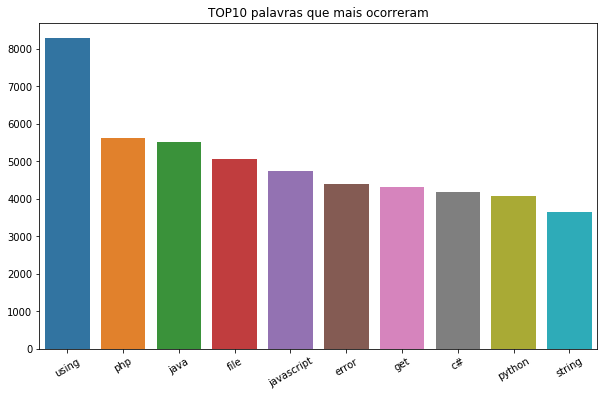

In [16]:
# colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = words_list, y = occur_list)

# inserindo o título
ax.set_title('TOP10 palavras que mais ocorreram')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

A palavra *using* é a que mais aparece, acredito que seja em função da maioria das perguntas serem sobre "como funciona" algo, em seguida entram algumas linguagens de programação, assim como buscas por erros.

Da mesma forma vamos fazer todo esse processo de contagem para as tags.

In [17]:
# realizando a contagem e inserindo em um dicionário
tags_counts = Counter(chain.from_iterable([i for i in y_train]))

# ordenando do maior para o menor
tags_freq = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)

Vamos também dar uma olhada no **TOP 10**, as 10 tags que mais apareceram.

In [18]:
tags_freq[:10]

[('javascript', 19078),
 ('c#', 19077),
 ('java', 18661),
 ('php', 13907),
 ('python', 8940),
 ('jquery', 7510),
 ('c++', 6469),
 ('html', 4668),
 ('objective-c', 4338),
 ('asp.net', 3939)]

Visualizando graficamente as **TOP 10** tags.

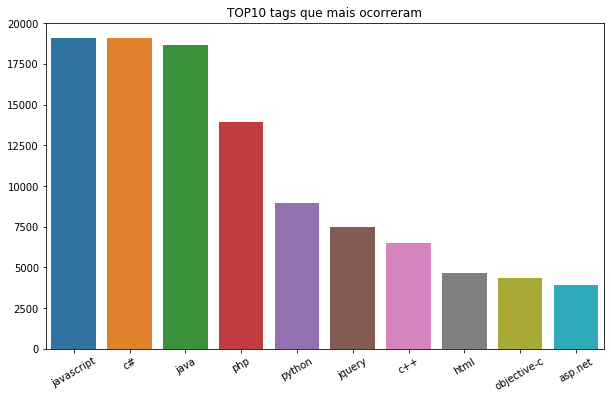

In [19]:
# colocando as palavras em um objeto do tipo lista
tags_list = list(dict(tags_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(tags_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = tags_list, y = occur_list)

# inserindo o título
ax.set_title('TOP10 tags que mais ocorreram')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

As tags que mais aparecem são linguagens de Programação, no qual são relacionadas com as perguntas, sobre o *uso* ou *erros* contidos nas perguntas, por exemplo.

## Transformando texto em vetor

Algoritmos de Machine Learning trabalham com **dados numéricos** e nós não podemos usar os textos da forma que conhecemos. Entretanto, devemos converter estes textos em **vetores numéricos**.

É denominado **vetorização** o processo geral de converter a coleção de textos em **vetores numéricos**. A estratégia de *tokenizar* (separar textos ou palavras em "blocos"), *contar* e *normalizar* (como já fizemos anteriormente) é chamado de representação **Bag of Words (BOW)**, ou na tradução literal **bolsa de palavras**, no qual são descritos pelas ocorrências das palavras enquanto são ignoradas suas posições relativas em todos os textos. Segue exemplo abaixo de como fica a estrutura, com a frequencia absoluta de cada palavra:

<img src="images/bag-of-word.png"/><center>*fig.1 - Imagem adaptada de text-analytics-beginners-nltk bootcamp*</center>
<br>

Um uso comum da Vetorização é a partir do `CountVectorizer` do `sklearn`, no qual vamos demonstrar em seguida.

Vamos *vetorizar* nossos dados, limitando à 5000 palavras, que na matriz serão apresentadas como 5000 colunas e daí entramos em um outro conceito que é de **esparsidade** e quanto mais colunas, mais poder computacional precisamos.

**Matriz esparsa** ou *Sparcity Matrix* são matrizes com muitos zeros, podemos visualizar na figura acima (fig.1), os espaços em branco quando a palavra não é encontrada em determinado documento, pois todos os documentos usam um conjunto muito pequenos de palavras e isso resulta nesse tipo de matriz.

In [20]:
# definindo um limite
max_features = 5000

# instanciando o vetorizador
vectorizer = CountVectorizer(max_features = max_features)

# aplicando a transformação
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)

# checando o shape
print('X_train shape:', X_train_bow.shape)
print('X_val shape:  ', X_val_bow.shape)

X_train shape: (100000, 5000)
X_val shape:   (30000, 5000)


Podemos certificar, como foi dito, que a construção resultou em uma matriz com 5000 colunas, que nós limitamos, em ambos os conjuntos, treino e validação.

## TF-IDF

Continuando, uma abordagem que se estende à estrutura da *Bag of Words* é capturar as **frequencias relativas** das palavras, pois ajuda a penalizar as palavras muito frequentes e otimiza o uso das melhores.

Nos textos, podemos nos deparar com uma quantidade de **palavras muito frequentes** que acabam carregando informações não muito relevantes e se treinarmos um modelo diretamente dessa forma, essas palavras podem **influenciar o modelo** e as palavras mais interessantes, porém menos frequentes não apareceriam. Segue exemplo abaixo:

<img src="images/tf-idf.png"/><center>*fig.2 - Imagem adaptada de text-analytics-beginners-nltk bootcamp*</center>
<br>

Então podemos fazer uso do **TF-IDF** que significa:<br>
**TF**: *term frequency* ou termos frequentes<br>
**IDF**: *inverse document-frequency* ou frequencia de documento inversa

Basicamente, a conta realizada é: *os termos frequentes nos documentos, ou seja, o número de vezes que eles ocorrem em um dado documento, é multiplicado com a componente inversa da frequencia* `tf-idf(t,d) = tf(t,d) x idf(t)`.

Vamos primeiramente instanciar o modelo para treinar o vetorizador a partir de alguns parâmetros, em seguida aplicaremos o modelo instanciado, treinando e transformando com os dados de treino e para os dados de validação somente a transformação, não deverá treinar novamente com esses dados. Em seguida extrairemos o vocabulário e por fim inverteremos a ordem do vocabulário (pois vamos utilizar mais a frente nessa estrutura).

In [21]:
# instanciando o tfidf
tfidf_vec = TfidfVectorizer(token_pattern = '(\S+)', min_df = 5, max_df = .9, ngram_range = (1,2))

# aplicando o modelo com fit_transform aos dados de treino
X_train_tfidf = tfidf_vec.fit_transform(X_train)

# aplicando o modelo com transform aos dados de validação
X_val_tfidf = tfidf_vec.transform(X_val)

# coletando o palavras
tfidf_vocab = tfidf_vec.vocabulary_

# invertendo o dicionário para termos a quantidade como chaves
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

## Multilabel Classifier

Chegamos o momento de treinarmos nosso modelo para fazer previsões, após deixarmos nossos conjuntos nas formas necessárias.

Para modelar essa predição, vamos converter a nossa variável alvo em **binário**, ou seja, a previsão será 0 e 1 e para isso vamos utilizar o algoritmo `MultiLabelBinarizer` do `sklearn`.

O transformador desse classificador converte uma lista de conjuntos ou tuplas em uma matriz binária (amostras x classes) indicando a presença de um rótulo de classe.

In [22]:
# instanciando o modelo
mlb = MultiLabelBinarizer(classes = sorted(tags_counts.keys()))

# convertendo rótulos de treino com fit_transform
y_train = mlb.fit_transform(y_train)

# transformando dados de validação com fit_transform
y_val = mlb.fit_transform(y_val)

Vamos conferir o resultado e a forma resultante nos 3 primeiros elementos.

In [23]:
# checando os 3 primeiros elementos das tags de treino
y_train[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [24]:
# checando os 3 primeiros elementos das tags de validação
y_val[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

Podemos também checar as classes que foram binarizadas.

In [25]:
# olhando as classes
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class',
       'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date',
       'datetime', 'django', 'dom', 'eclipse', 'entity-framework',
       'excel', 'facebook', 'file', 'forms', 'function', 'generics',
       'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel',
       'linq', 'linux', 'list', 'loops', 'maven', 'mongodb',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php',
       'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r',
       'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring',
       'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing',
       'twitter-bootstrap'

Após treinar o classificador, vamos utilizar também utilizar uma abordagem de **um contra todos** com `OneVsRestClassifier` também do `sklearn`.

Nesta abordagem o **k classificadores (= número de tags)** são treinados. Essa estratégia consiste em treinar **um classificador por classe**, para cada classificador, a classe é treinada contra todas as outras. 

A vantagem disso é pela a interpretabilidade, cada classe é representada um e somente um classificador, sendo possível ganhar conhecimento sobre a classe pelo classificador correspondente. Esta é a **estratégia mais comumente usada para classificação multiclasse**.

Depois usaremos a **Regressão Logística** ou `LogisticRegression` do `sklearn`, embora um método mais simples, mas que frequentemente tem um boa performance em tarefas de **classificação de textos**.

Vamos criar um função para facilitar nosso treinamento, pois queremos fazer tanto para *bag-of-words* quanto para *tf-idf* e colocaremos alguns dos parâmetros mais importantes desse modelo, assim facilitará caso queiramos tentar melhora-lo posteriormente.

# Treinando e testando

Agora vamos utilizar a Regressão Logística dentro do OneVsRestClassifier para treinar e depois validar o modelo.

In [26]:
# criando a função
def train_classifier(X_train, y_train, C=2.5, penalty='l2'):
    
    # instanciando a regressão logística
    logreg = LogisticRegression(C=C, penalty=penalty, max_iter=2000)

    
    # intanciando o modelo de um contra todos com a regressão logística
    one_vs_rest = OneVsRestClassifier(logreg).fit(X_train, y_train)
    
    # retornando o instancia do modelo
    return one_vs_rest

Vamos aplicar a função.

In [27]:
# treinando um classificador com bow
classifier_bow = train_classifier(X_train_bow, y_train)

# treinando um classificador com tf-idf
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Agora podemos criar as previsões e vamos utilizar agora o conjunto de dados de validação. Utilizaremos dois tipos de previsões: *labels* que são pelas classes e *scores* pela pontuação.

In [28]:
# realizando as previsões com labels
y_val_predicted_labels_bow = classifier_bow.predict(X_val_bow)

# realizando as previsões com scores
y_val_predicted_scores_bow = classifier_bow.decision_function(X_val_bow)

# realizando as previsões com labels
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

# realizando as previsões com scores
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Agora veja como um classificador que usa o TF-IDF funciona, alguns exemplos:

In [29]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(5):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




## Avaliação

Para avaliação do modelo, usaremos algumas métricas de classificação:
- Accuracy
- F1-score
- Area under ROC-curve


Resumo dessa métricas:

***Accuracy***: é a mais simples das métricas e nos mostra de uma forma geral o quanto o modelo está performando, dividindo o número de acertos (positivos) pelo total dos dados de entrada.

***F1-score***: é a média harmônica entre precisão e recall.
    - precisão: é a taxa de números positivos divididos pela soma do total de positivos e falso positivos. Ele descreve o quão bom o modelo é, em prever a classe positiva.
    - recall: é calculada como a taxa de números de verdadeiros positivos divido pela soma dos verdadeiros positivos e falso negativos. Recall é o mesmo que sensibilidade.

***ROC-curve***: é obtido pela divisão dos positivos verdadeiros pelos positivos totais (RPV) versus a divisão dos falsos positivos pelo negativos totais (RPF), para vários valores do limiar de classificação. O RPV é também conhecido como sensibilidade (ou taxa de verdadeiros positivos), e RPF = 1-especificidade ou taxa de falsos positivos. A especificidade é conhecida como taxa de verdadeiros negativos (RVN).

Vamos implementar a função *print_evaluation_scores* para calcular e imprimir os resultados da:
 - *accuracy*
 - *F1-score*
 - *Precision*

Para as métricas de *F1-score* e *precision* vamos alternar o parâmetro *average* entre *micro/macro/weighted*.
- *micro*: calcula métricas globais contando o total de verdadeiros positivos, falso negativos e falso positivos.
- *macro*: calcula métricas para cada rótulo (label), e encontra sua média não-ponderada. O desbalanceamento não é levado em consideração.
- *weighted*: calcula métricas para cada rótulo, e encontra a média ponderada por suporte (o número de instâncias verdadeiras para cada rótulo). 

In [30]:
# criando a função para avaliação
def print_evaluation_scores(y_val, predicted):
    
    # calculando a acuracia
    print("Accuracy score :",accuracy_score(y_true=y_val,y_pred=predicted))
    
    # calculando f1 score
    print("F1 averaged score :",np.mean(np.array(f1_score(y_true=y_val, y_pred=predicted, average = 'micro'))))
    
    # calculando a precision score
    print("Precision score :",average_precision_score(y_true=y_val, y_score=predicted, average = 'weighted'))

Os parâmetros acima, foram os que tiveram melhor resultado.

In [31]:
print('Bag-of-words')
print('---------------------------------------------')
print_evaluation_scores(y_val, y_val_predicted_labels_bow)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('\nTfidf')
print('---------------------------------------------')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

Bag-of-words
---------------------------------------------
Accuracy score : 0.3298333333333333
F1 averaged score : 0.6517060286212482
Precision score : 0.4862752823111001
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Tfidf
---------------------------------------------
Accuracy score : 0.35746666666666665
F1 averaged score : 0.666300826306736
Precision score : 0.506852648478541
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Vamos também plotar a [Curva ROC](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) para casos de classificação *multi-labels*, que é o nosso caso. Os parâmetros de entrada são:
- true labels (rótulos verdadeiros)
- decision funcions scores (previsão por scores)
- number of classes (número das classes)

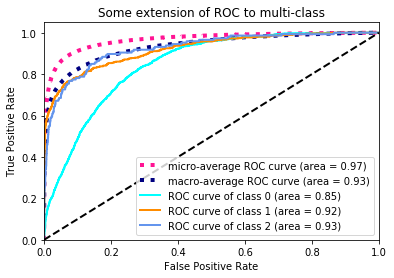

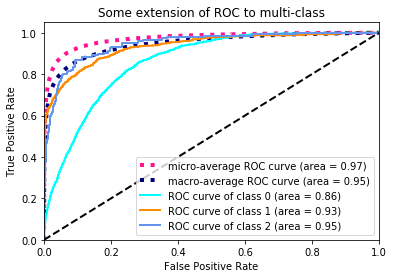

In [32]:
# número de classes
n_classes = len(tags_counts)

# plotanco a curva para bow
roc_auc(y_val, y_val_predicted_scores_bow, n_classes)

# número de classes
n_classes = len(tags_counts)

# plotanco a curva para tf-idf
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

O resultado da curva ROC, quanto mais próximo de 1, melhor. Ela nos mostra, de uma forma simplificada, o quanto nosso classificador é bom em acertar as diferentes classes.

## Análises das variáveis mais importantes

Para finalizar, vamos dar uma olhada nas variáveis que mais influenciam nosso classificador (palavras ou *n-grams*) que são usados com pesos maiores com o classificador da Regressão Logística.

Vamos construir nossa função para exibir essas variáveis. Essa função será criada com os seguinte parâmetros:
- **classifier**: classificador treinado;
- **tag**: tag particular (selecione uma desejada);
- **tags_classes**: uma lista de nomes de classes do MultiLabelBinarizer
- **index_to_words**: transformação index_to_words
- **all_words**: todas as palavras no dicionário

In [33]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):

    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    est = classifier.estimators_[tags_classes.index(tag)]
    
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [34]:
# all_words_text = list(words_counts.keys())

# print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, all_words_text)
# print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, all_words_text)
# print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, all_words_text)

lista_palavras = ['c', 'c++', 'linux']

all_words_text = list(words_counts.keys())

for w in lista_palavras:
    print_words_for_tag(classifier_tfidf, w, mlb.classes, tfidf_reversed_vocab, all_words_text)

Tag:	c
Top positive words:	gcc, printf, scanf, malloc, c
Top negative words:	php, java, python, javascript, c#

Tag:	c++
Top positive words:	c++11, mfc, boost, qt, c++
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	unix, address, signal, ubuntu, linux
Top negative words:	javascript, c#, jquery, array, method



Podemos observar as top mais, que influenciam tanto positivamente quanto negativamente as nossas classes. Podemos inserir as palavras na lista definida acima antes de rodar a função.

E agora só um exemplo de como podemos tunar a regressão logística de forma mais simplificada com a função que foi criada mais acima.

## Tunando hiperparâmetros

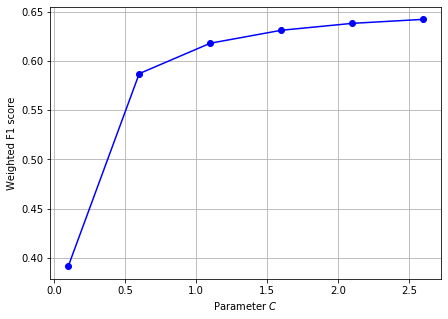

In [35]:
hypers = np.arange(0.1, 3.0, 0.5)
res = []

for h in hypers:
    temp_model = train_classifier(X_train_tfidf, y_train, C=h)
    temp_pred = f1_score(y_val, temp_model.predict(X_val_tfidf), average='weighted')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

## Conclusão

Neste artigo apresentamos um tutorial passando pelas diversas etapas de como preparar documentos ou textos e aplicar um modelo linear para classificação mult-labels, onde o mais que se encontra são classificações binárias com esse classificador, a proposta era trazer algo diferente relacionado também ao estudo de NLP, e podemos também utilizar outras formas para melhorar ainda mais o resultado do nosso modelo, como tunar o tf-idf e outros parâmetros da Regressão Logística ou até mesmo utilizar outro modelo.

Não foram abordados temas como conceitos de tokenização e n-grams que ficará para um próximo projeto, abaixo deixarei as referências utilizadas para realizar este.

## Referências

Processamento de linguagem natural<br>
https://bit.ly/31TQkwX

Tectudo: Stack Overflow – Conheça o melhor site de perguntas e respostas de programação<br>
https://glo.bo/2PSfeHA

Multilabel Binarizer<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

OneVsRestClassifier<br>
http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

LogisticRegression<br>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Count Vectorizer<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Feature Extraction (Bag-of-word, tfidf)<br>
https://scikit-learn.org/stable/modules/feature_extraction.html

ROC Curve<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

NLP Tutorial: MultiLabel Classification Problem using Linear Models<br>
https://gdcoder.com/nlp-tutorial-multilabel-claddification-problem-using-linear-models/